# Window selection: LASSO
25 March 2024  
Conda environment: `time-series`

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.linear_model import Lasso

from feature_engine.timeseries.forecasting import LagFeatures, WindowFeatures, ExpandingWindowFeatures
from feature_engine.imputation import DropMissingData
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
# Configs
# Plot configs:
sns.set_context("paper", font_scale= 1.5)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plotsize = (22, 5)
plt.rcParams['figure.figsize'] = plotsize
# Pandas config
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_columns = 200

## 1) Input data

In [5]:
data = pd.read_csv(
    "../Datasets/victoria_electricity_demand.csv",
    usecols=["demand", "temperature", "date_time"],
    index_col=["date_time"],
    parse_dates=["date_time"],
)

# For this demo we will use a subset of the data
data = data.loc["2010":]
data

,demand,temperature
date_time,,
2010-01-01 00:00:00,"8,314.4487",21.5250
2010-01-01 01:00:00,"8,267.1873",22.4000
2010-01-01 02:00:00,"7,394.5284",22.1500
2010-01-01 03:00:00,"6,952.0475",21.8000
2010-01-01 04:00:00,"6,867.1996",20.2500
...,...,...
2015-02-28 19:00:00,"9,596.7771",28.3500
2015-02-28 20:00:00,"8,883.2303",22.2000
2015-02-28 21:00:00,"8,320.2605",18.9000


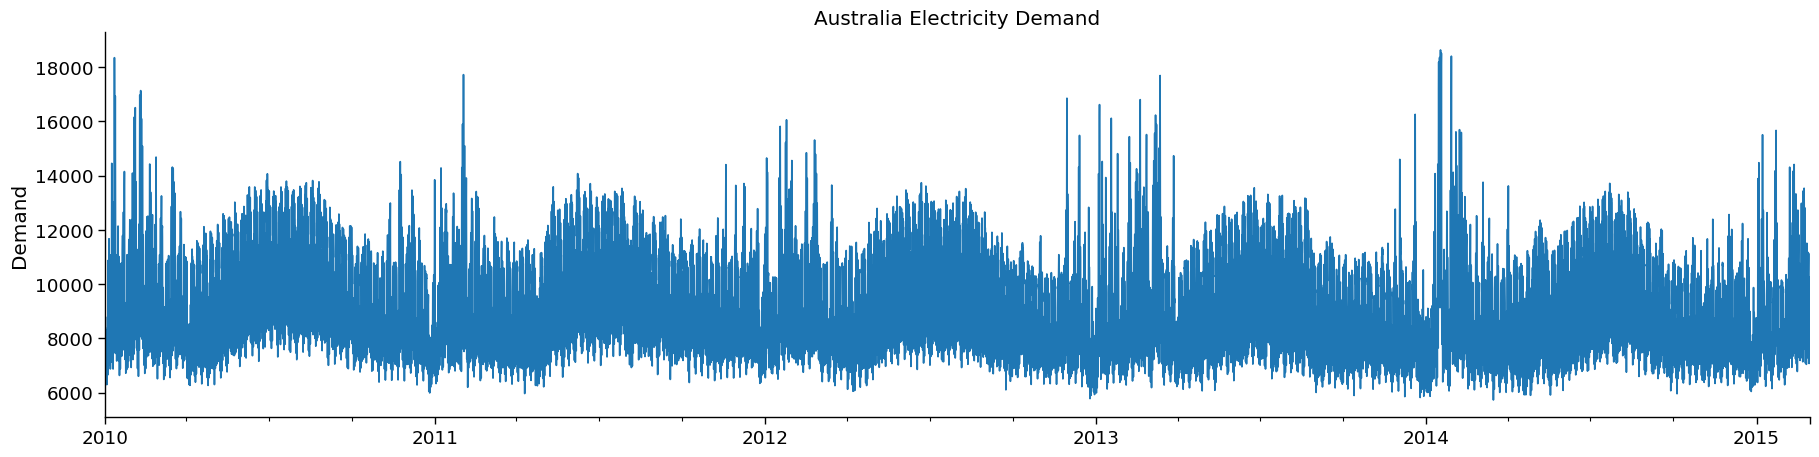

In [6]:
data["demand"].plot()

plt.title("Australia Electricity Demand")
plt.ylabel("Demand")
plt.xlabel("")
plt.show()

## 2) Create Lag & Window feaures

In [7]:
df = data.copy(deep=True)

In [9]:
df.head()

,demand,temperature
date_time,,
2010-01-01 00:00:00,"8,314.4487",21.5250
2010-01-01 01:00:00,"8,267.1873",22.4000
2010-01-01 02:00:00,"7,394.5284",22.1500
2010-01-01 03:00:00,"6,952.0475",21.8000
2010-01-01 04:00:00,"6,867.1996",20.2500


In [15]:
# Lag features
lag_transformer = LagFeatures(
                        variables=["demand", "temperature"],
                        periods=[1, 2, 3, 24, 24 * 7]
                )

# Rolling Window features
window_transformer = WindowFeatures(
    variables=["demand", "temperature"],
    functions=["mean", "std", "kurt", "skew"],
    window=[24, 24 * 7, 24 * 7 * 4, 24 * 7 * 4 * 12], # window => 1day, 1week, 1month, 1year
    periods=1,
)

# Expanding Window features: by default this will lag our features by one period.
expanding_window_transformer = ExpandingWindowFeatures(
    variables=["demand"], 
    functions=["mean", "std", "kurt", "skew"]
)

# Drop missing data introduced by window and lag features
imputer = DropMissingData()

# Pipeline
pipe = Pipeline(
    [
        ("lag", lag_transformer),
        ("rolling", window_transformer),
        ("expanding", expanding_window_transformer),
        ("drop_missing", imputer)
    ]
)

df = pipe.fit_transform(df)
df

,demand,temperature,demand_lag_1,temperature_lag_1,demand_lag_2,temperature_lag_2,demand_lag_3,temperature_lag_3,demand_lag_24,temperature_lag_24,demand_lag_168,temperature_lag_168,demand_window_24_mean,demand_window_24_std,demand_window_24_kurt,demand_window_24_skew,temperature_window_24_mean,temperature_window_24_std,temperature_window_24_kurt,temperature_window_24_skew,demand_window_168_mean,demand_window_168_std,demand_window_168_kurt,demand_window_168_skew,temperature_window_168_mean,temperature_window_168_std,temperature_window_168_kurt,temperature_window_168_skew,demand_window_672_mean,demand_window_672_std,demand_window_672_kurt,demand_window_672_skew,temperature_window_672_mean,temperature_window_672_std,temperature_window_672_kurt,temperature_window_672_skew,demand_window_8064_mean,demand_window_8064_std,demand_window_8064_kurt,demand_window_8064_skew,temperature_window_8064_mean,temperature_window_8064_std,temperature_window_8064_kurt,temperature_window_8064_skew,demand_expanding_mean,demand_expanding_std,demand_expanding_kurt,demand_expanding_skew
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-12-03 00:00:00,"7,650.1658",17.8250,"8,311.6414",18.3250,"8,194.7589",18.6500,"8,810.2259",19.0000,"7,594.9659",18.5000,"7,789.4929",16.5750,"9,770.1023","1,618.6866",-1.4169,-0.3633,19.9219,2.2132,1.0168,1.2111,"9,209.0092","1,491.5826",-1.2888,0.0608,18.2274,3.0969,-0.8357,0.2024,"9,357.7340","1,691.0683",-0.4220,0.4956,18.5100,4.8153,0.0862,0.6648,"9,842.0906","1,804.1884",-0.1039,0.4225,15.7444,5.7427,0.6594,0.7782,"9,842.0906","1,804.1884",-0.1039,0.4225
2010-12-03 01:00:00,"7,927.1404",17.8500,"7,650.1658",17.8250,"8,311.6414",18.3250,"8,194.7589",18.6500,"7,914.5380",18.3750,"8,112.2868",16.4500,"9,772.4023","1,615.4976",-1.4166,-0.3616,19.8938,2.2362,0.9406,1.1883,"9,208.1798","1,492.4150",-1.2903,0.0607,18.2348,3.0944,-0.8310,0.1965,"9,357.4978","1,691.2960",-0.4226,0.4955,18.5202,4.8066,0.0940,0.6676,"9,842.0082","1,804.2733",-0.1042,0.4224,15.7439,5.7424,0.6604,0.7784,"9,841.8188","1,804.2416",-0.1041,0.4226
2010-12-03 02:00:00,"7,327.1461",17.6750,"7,927.1404",17.8500,"7,650.1658",17.8250,"8,311.6414",18.3250,"7,321.4281",17.8750,"7,445.5770",16.2500,"9,772.9274","1,614.8694",-1.4155,-0.3616,19.8719,2.2542,0.8824,1.1710,"9,207.0778","1,493.2972",-1.2927,0.0614,18.2432,3.0914,-0.8253,0.1901,"9,357.1227","1,691.5856",-0.4235,0.4955,18.5312,4.7965,0.1018,0.6721,"9,841.9660","1,804.3141",-0.1043,0.4224,15.7434,5.7420,0.6615,0.7787,"9,841.5814","1,804.2557",-0.1041,0.4228
2010-12-03 03:00:00,"7,088.7258",17.6250,"7,327.1461",17.6750,"7,927.1404",17.8500,"7,650.1658",17.8250,"7,045.3151",17.4250,"7,205.9427",16.1750,"9,773.1656","1,614.4924",-1.4162,-0.3612,19.8635,2.2623,0.8574,1.1597,"9,206.3728","1,494.1615",-1.2931,0.0606,18.2516,3.0879,-0.8183,0.1840,"9,356.6947","1,692.0634",-0.4245,0.4949,18.5425,4.7856,0.1095,0.6778,"9,841.9577","1,804.3256",-0.1043,0.4224,15.7428,5.7416,0.6627,0.7790,"9,841.2697","1,804.3610",-0.1044,0.4229
2010-12-03 04:00:00,"7,458.3148",17.6250,"7,088.7258",17.6250,"7,327.1461",17.6750,"7,927.1404",17.8500,"7,396.8970",17.2750,"7,613.4566",16.4750,"9,774.9744","1,611.3246",-1.4272,-0.3562,19.8719,2.2533,0.8833,1.1752,"9,205.6751","1,495.1283",-1.2925,0.0592,18.2603,3.0841,-0.8105,0.1780,"9,356.2972","1,692.5655",-0.4252,0.4940,18.5544,4.7733,0.1165,0.6853,"9,841.9746","1,804.2991",-0.1043,0.4224,15.7423,5.7412,0.6637,0.7793,"9,840.9286","1,804.5094",-0.1047,0.4228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-02-28 19:00:00,"9,596.7771",28.3500,"9,979.9099",30.8500,"10,258.5854",31.5500,"10,019.9216",31.2500,"9,980.1088",19.7000,"12,259.0117",31.1500,"8,802.5657",974.7597,-0.9416,-0.4268,21.8563,5.1417,-0.7644,0.8756,"9,670.4635","1,539.9929",-0.4652,0.2374,21.0857,4.8404,-0.3893,0.6756,"9,626.9860","1,714.5256",-0.3278,0.4

### 2.1) Train/Test split

In [16]:
# We'll hold the most recent day as a test set
split_date = df.index[-1] - pd.Timedelta("1D")
df_train = df[df.index <= split_date]
df_test =  df[df.index > split_date]

display(df_train.tail())
display(df_test.head())

,demand,temperature,demand_lag_1,temperature_lag_1,demand_lag_2,temperature_lag_2,demand_lag_3,temperature_lag_3,demand_lag_24,temperature_lag_24,demand_lag_168,temperature_lag_168,demand_window_24_mean,demand_window_24_std,demand_window_24_kurt,demand_window_24_skew,temperature_window_24_mean,temperature_window_24_std,temperature_window_24_kurt,temperature_window_24_skew,demand_window_168_mean,demand_window_168_std,demand_window_168_kurt,demand_window_168_skew,temperature_window_168_mean,temperature_window_168_std,temperature_window_168_kurt,temperature_window_168_skew,demand_window_672_mean,demand_window_672_std,demand_window_672_kurt,demand_window_672_skew,temperature_window_672_mean,temperature_window_672_std,temperature_window_672_kurt,temperature_window_672_skew,demand_window_8064_mean,demand_window_8064_std,demand_window_8064_kurt,demand_window_8064_skew,temperature_window_8064_mean,temperature_window_8064_std,temperature_window_8064_kurt,temperature_window_8064_skew,demand_expanding_mean,demand_expanding_std,demand_expanding_kurt,demand_expanding_skew
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-02-27 19:00:00,"9,980.1088",19.7000,"10,068.0406",20.8500,"10,483.5364",21.5500,"10,960.2560",22.5000,"10,190.8025",19.7000,"11,008.4552",21.8000,"9,525.6240","1,264.9518",-1.1242,-0.5950,18.8187,3.1345,-1.2287,0.0733,"9,845.9514","1,666.1411",-0.6316,0.2202,21.4658,5.3301,-0.1162,0.8200,"9,597.6124","1,730.6408",-0.3580,0.4454,20.4885,4.9129,0.2161,0.9267,"9,196.6092","1,604.7957",-0.4013,0.2938,15.9755,5.2388,1.0633,0.7922,"9,464.0041","1,752.3023",0.2514,0.4996
2015-02-27 20:00:00,"9,411.8746",18.7500,"9,980.1088",19.7000,"10,068.0406",20.8500,"10,483.5364",21.5500,"9,610.0252",18.6000,"10,328.2451",20.1500,"9,516.8451","1,260.8591",-1.1172,-0.5828,18.8187,3.1345,-1.2287,0.0733,"9,839.8303","1,663.7319",-0.6156,0.2303,21.4533,5.3318,-0.1119,0.8261,"9,598.9885","1,730.5766",-0.3591,0.4431,20.4920,4.9115,0.2169,0.9257,"9,196.6918","1,604.8189",-0.4015,0.2936,15.9757,5.2389,1.0629,0.7920,"9,464.0155","1,752.2846",0.2515,0.4996
2015-02-27 21:00:00,"8,653.5110",18.3000,"9,411.8746",18.7500,"9,980.1088",19.7000,"10,068.0406",20.8500,"8,719.9302",17.8000,"9,352.0482",18.9000,"9,508.5889","1,260.8712",-1.1351,-0.5614,18.8250,3.1342,-1.2286,0.0668,"9,834.3757","1,663.6232",-0.6118,0.2401,21.4449,5.3350,-0.1132,0.8287,"9,599.6568","1,730.4173",-0.3588,0.4421,20.4961,4.9089,0.2197,0.9258,"9,196.7815","1,604.8107",-0.4015,0.2934,15.9758,5.2389,1.0627,0.7920,"9,464.0143","1,752.2652",0.2516,0.4996
2015-02-27 22:00:00,"8,256.6831",18.1500,"8,653.5110",18.3000,"9,411.8746",18.7500,"9,980.1088",19.7000,"8,271.4870",17.8000,"8,744.2612",18.7500,"9,505.8214","1,262.7490",-1.1513,-0.5549,18.8458,3.1288,-1.2156,0.0468,"9,830.2177","1,665.7075",-0.6200,0.2447,21.4414,5.3369,-0.1147,0.8293,"9,600.1095","1,730.1294",-0.3578,0.4419,20.5004,4.9057,0.2231,0.9265,"9,196.8614","1,604.7676",-0.4013,0.2934,15.9759,5.2390,1.0624,0.7919,"9,463.9964","1,752.2500",0.2516,0.4996
2015-02-27 23:00:00,"8,716.4983",17.8000,"8,256.6831",18.1500,"8,653.5110",18.3000,"9,411.8746",18.7500,"8,800.9006",17.6500,"9,066.6167",18.3000,"9,505.2046","1,263.3816",-1.1546,-0.5541,18.8604,3.1245,-1.2049,0.0330,"9,827.3155","1,668.0341",-0.6280,0.2456,21.4378,5.3389,-0.1164,0.8297,"9,600.4960","1,729.7998",-0.3567,0.4419,20.5053,4.9017,0.2274,0.9279,"9,196.9304","1,604.7152",-0.4011,0.2933,15.9761,5.2390,1.0622,0.7918,"9,463.9697","1,752.2398",0.2517,0.4996


,demand,temperature,demand_lag_1,temperature_lag_1,demand_lag_2,temperature_lag_2,demand_lag_3,temperature_lag_3,demand_lag_24,temperature_lag_24,demand_lag_168,temperature_lag_168,demand_window_24_mean,demand_window_24_std,demand_window_24_kurt,demand_window_24_skew,temperature_window_24_mean,temperature_window_24_std,temperature_window_24_kurt,temperature_window_24_skew,demand_window_168_mean,demand_window_168_std,demand_window_168_kurt,demand_window_168_skew,temperature_window_168_mean,temperature_window_168_std,temperature_window_168_kurt,temperature_window_168_skew,demand_window_672_mean,demand_window_672_std,demand_window_672_kurt,demand_window_672_skew,temperature_window_672_mean,temperature_window_672_std,temperature_window_672_kurt,temperature_window_672_skew,demand_window_8064_mean,demand_window_8064_std,demand_window_8064_kurt,demand_window_8064_skew,temperature_window_8064_mean,temperature_window_8064_std,temperature_window_8064_kurt,temperature_window_8064_skew,demand_expanding_mean,demand_expanding_std,demand_expanding_kurt,demand_expanding_skew
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-02-28 00:00:00,"8,003.2290",17.6500,"8,716.4983",17.8000,"8,256.6831",18.1500,"8,653.5110",18.3000,"8,121.8687",17.0500,"8,239.6207",18.1500,"9,501.6878","1,265.5430",-1.1743,-0.5455,18.8667,3.1221,-1.1989,0.0274,"9,825.2314","1,669.2085",-0.6327,0.2476,21.4348,5.3408,-0.1181,0.8298,"9,600.7676","1,729.6464",-0.3562,0.4417,20.5107,4.8967,0.2324,0.9304,"9,196.9925","1,604.6869",-0.4010,0.2933,15.9763,5.2390,1.0620,0.7916,"9,463.9532","1,752.2240",0.2517,0.4997
2015-02-28 01:00:00,"7,522.8626",17.2000,"8,003.2290",17.6500,"8,716.4983",17.8000,"8,256.6831",18.1500,"7,629.7962",16.5500,"7,667.6130",17.8000,"9,496.7445","1,271.3852",-1.1952,-0.5423,18.8917,3.1093,-1.1679,0.0081,"9,823.8243","1,670.6522",-0.6364,0.2469,21.4318,5.3428,-0.1198,0.8299,"9,601.0035","1,729.4174",-0.3555,0.4419,20.5174,4.8897,0.2384,0.9351,"9,197.0523","1,604.6334",-0.4008,0.2933,15.9764,5.2391,1.0618,0.7915,"9,463.9209","1,752.2180",0.2518,0.4997
2015-02-28 02:00:00,"7,156.3104",17.2000,"7,522.8626",17.2000,"8,003.2290",17.6500,"8,716.4983",17.8000,"7,316.7748",15.9500,"7,283.4834",17.9500,"9,492.2889","1,278.3805",-1.1889,-0.5489,18.9187,3.0908,-1.1269,-0.0076,"9,822.9627","1,671.8078",-0.6375,0.2451,21.4283,5.3454,-0.1222,0.8295,"9,601.5367","1,728.7201",-0.3546,0.4431,20.5236,4.8828,0.2439,0.9401,"9,197.1310","1,604.5357",-0.4006,0.2934,15.9766,5.2391,1.0616,0.7914,"9,463.8779","1,752.2224",0.2517,0.4997
2015-02-28 03:00:00,"7,074.6768",17.2000,"7,156.3104",17.2000,"7,522.8626",17.2000,"8,003.2290",17.6500,"7,280.9014",15.3000,"7,136.7080",18.3000,"9,485.6029","1,290.6144",-1.1370,-0.5705,18.9708,3.0488,-1.0422,-0.0285,"9,822.2057","1,672.9929",-0.6368,0.2426,21.4238,5.3486,-0.1252,0.8292,"9,602.2314","1,727.6415",-0.3548,0.4456,20.5287,4.8775,0.2489,0.9436,"9,197.2148","1,604.4114",-0.4005,0.2937,15.9768,5.2391,1.0614,0.7913,"9,463.8269","1,752.2367",0.2517,0.4997
2015-02-28 04:00:00,"7,204.0319",17.2000,"7,074.6768",17.2000,"7,156.3104",17.2000,"7,522.8626",17.2000,"7,603.8327",14.2500,"7,180.5696",18.1500,"9,477.0102","1,306.5196",-1.0691,-0.5986,19.0500,2.9731,-0.9137,-0.0387,"9,821.8365","1,673.5959",-0.6361,0.2413,21.4173,5.3532,-0.1292,0.8291,"9,603.0068","1,726.3878",-0.3555,0.4488,20.5345,4.8712,0.2543,0.9480,"9,197.3028","1,604.2755",-0.4005,0.2940,15.9770,5.2391,1.0613,0.7912,"9,463.7741","1,752.2533",0.2516,0.4997


### 2.3) LASSO

In [17]:
# Create target variable
y_train = df_train["demand"]

# Drop demand and temperature as features, we do not know them at predict time.
X_train = df_train.drop(columns=["demand", "temperature"])

In [18]:
X_train_ = StandardScaler().fit_transform(X_train)
X_train = pd.DataFrame(data=X_train_, columns=X_train.columns)

In [20]:
# LASSO model
ALPHA = 1
SEED = 0
model = Lasso(alpha=ALPHA, random_state=SEED)
model.fit(X_train, y_train)

Lasso(alpha=1, random_state=0)

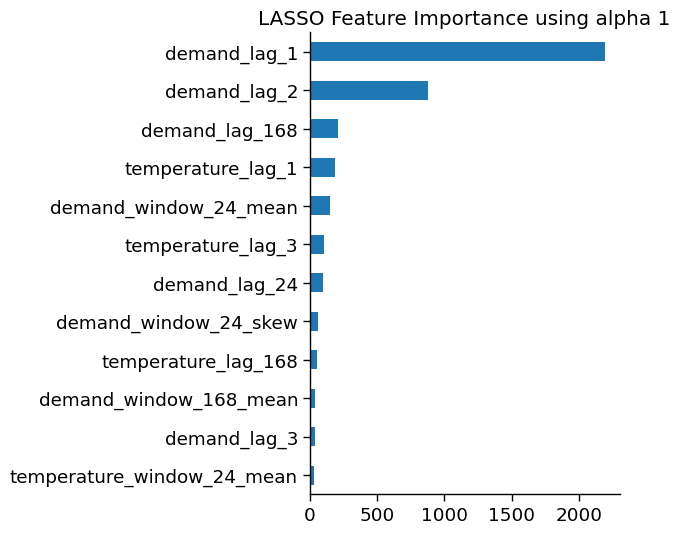

In [36]:
TOP_N = 12
pd.Series(index=X_train.columns, data=model.coef_)\
    .abs()\
    .nlargest(TOP_N)\
    [::-1]\
    .plot(kind="barh", figsize=(4,6))

plt.title(f"LASSO Feature Importance using alpha {ALPHA}")
plt.show()